# Evaluating pairs of detectors

## Setup

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import random

In [2]:
sys.path.append(os.path.join(".."))
from src.data.scoreloader import Scoreloader
from src.data.dataloader import Dataloader

### Paths

In [3]:
# Dataloader & Scoreloader
data_dir = os.path.join("..", "data")
scores_dir = os.path.join(data_dir, "scores")
dataloader = Dataloader(os.path.join(data_dir, "raw"), os.path.join(data_dir, "TSB_128"), os.path.join(data_dir, "features", "TSFRESH_TSB_128"))
scoreloader = Scoreloader(scores_dir)

In [4]:
# Results path
results_dir = os.path.join("..", "reports", "matrices_04_2024")

### Variables

In [5]:
datasets = [x for x in dataloader.get_dataset_names() if "NASA" not in x]

In [6]:
detectors = scoreloader.get_detector_names()

In [7]:
cmaps = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 
'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 
'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 
'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 
'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 
'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 
'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 
'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn',
'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 
'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 
'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r',
'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 
'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 
'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 
'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r',
'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 
'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 
'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 
'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']

# "rocket_r", "YlOrRd", "gnuplot2_r", "hot_r"
pallete = random.choice(cmaps)
print(pallete)

CMRmap


### Helper functions

In [8]:
def dataframe_to_matrix(df, fnames, detectors):
    """
    Convert the DataFrame back to a matrix.
    
    Parameters:
        df (pandas.DataFrame): The DataFrame to be converted.
        fnames (list): List of time series names.
        detectors (list): List of detector names.
        
    Returns:
        numpy.ndarray: The matrix containing the data from the DataFrame.
    """
    n_time_series = len(fnames)
    n_detectors = len(detectors)
    
    matrix = np.zeros((n_time_series, n_detectors, n_detectors))
    
    for idx, row in df.iterrows():
        ts_idx = fnames.index(row['Time Series'])
        det_pair = row['Detector Pair'].split('-')
        det1_idx = detectors.index(det_pair[0])
        det2_idx = detectors.index(det_pair[1])
        
        matrix[ts_idx][det1_idx][det2_idx] = row['AUC-PR']
    
    return matrix

## Load and display data

In [9]:
matrices = []
dfs = []

for dataset in datasets:
    loaded_df = pd.read_csv(os.path.join(results_dir, f"matrix_{dataset}.csv"))
    fnames = loaded_df['Time Series'].unique().tolist()
    matrices.append(dataframe_to_matrix(loaded_df, fnames, detectors))
    dfs.append(loaded_df)

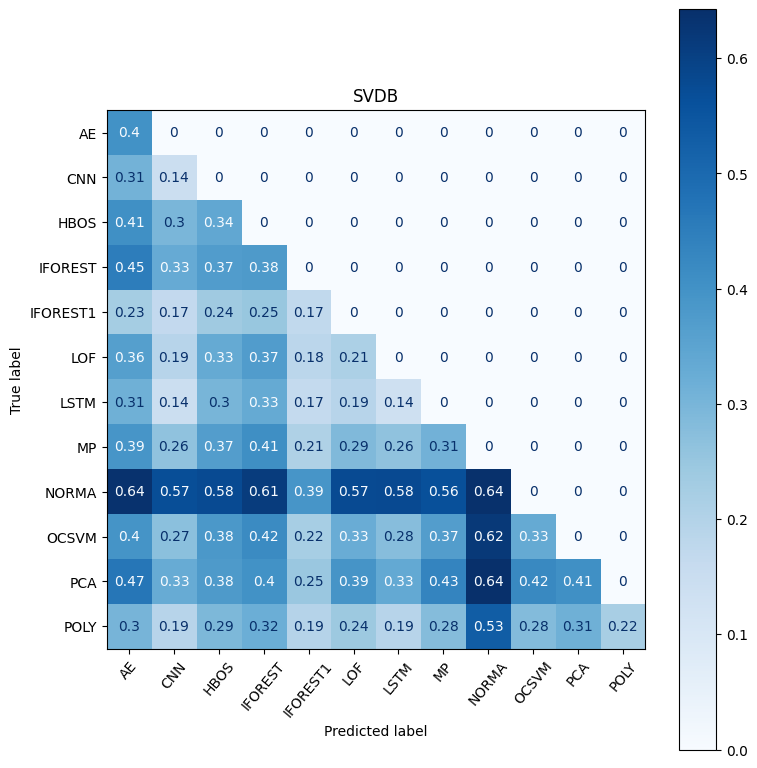

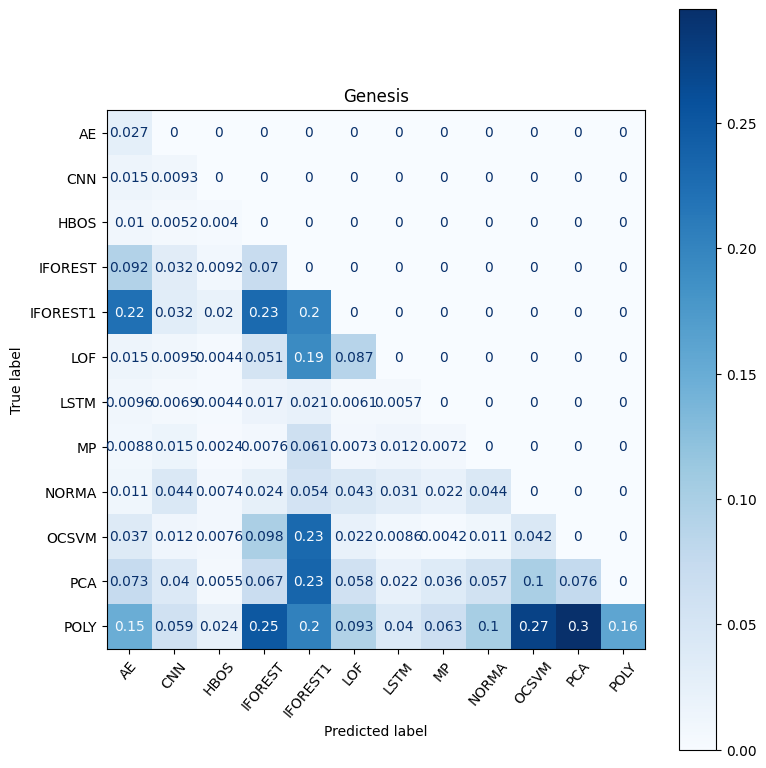

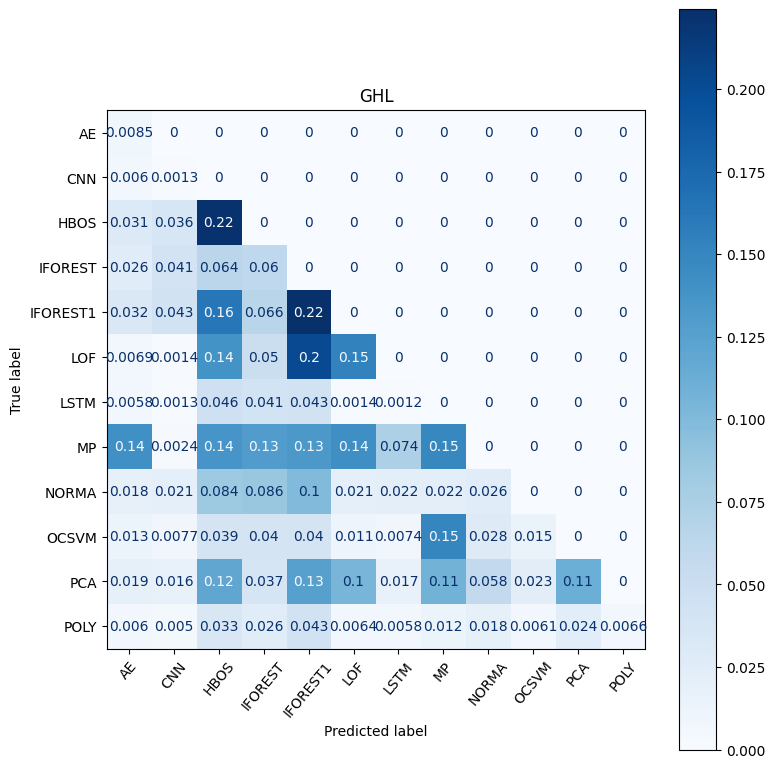

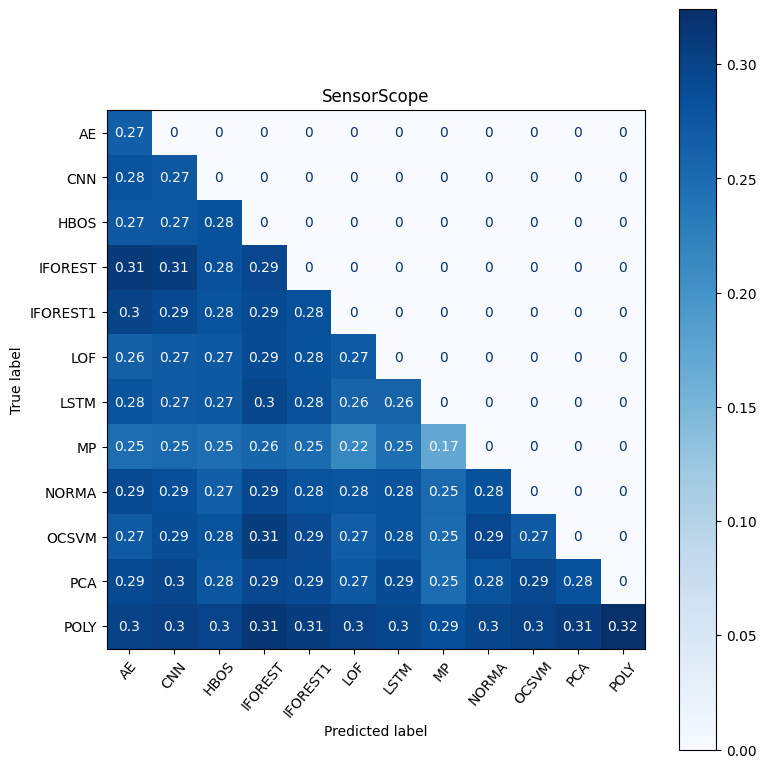

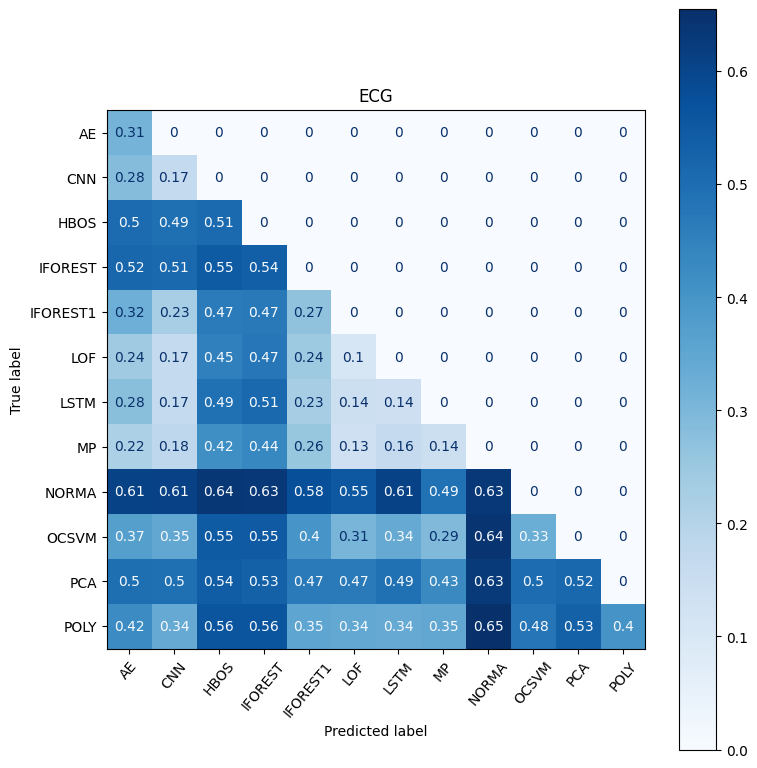

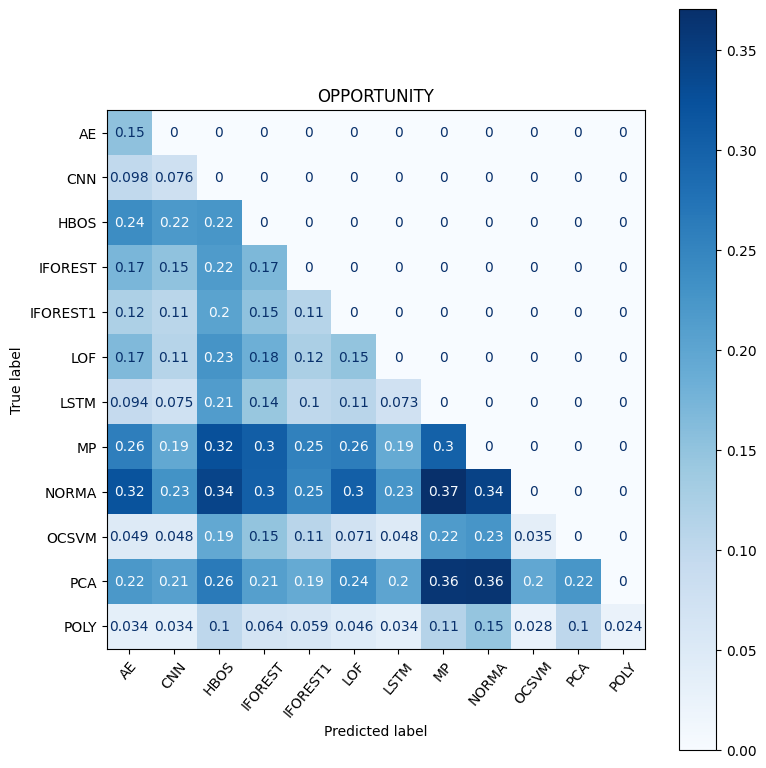

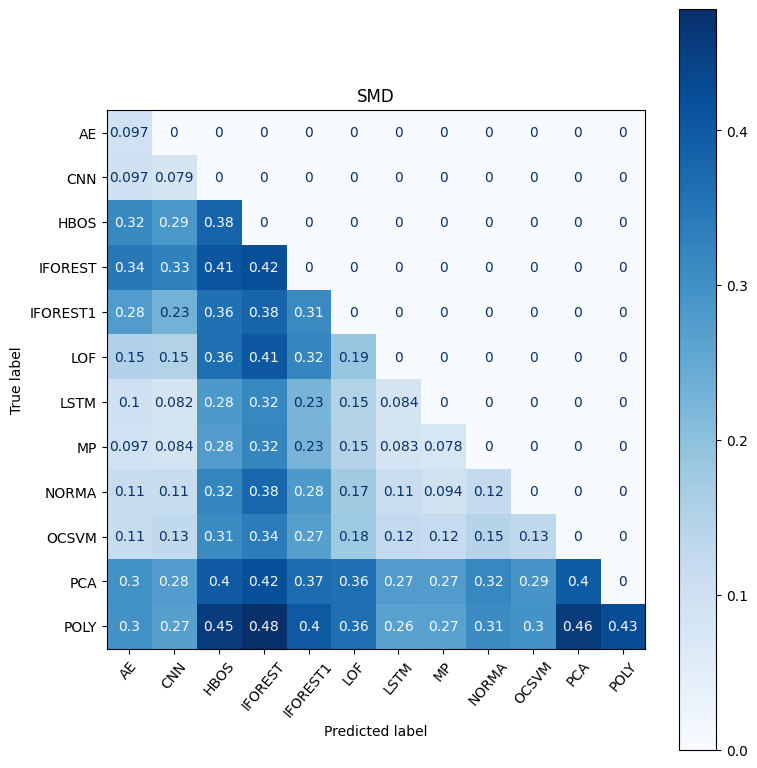

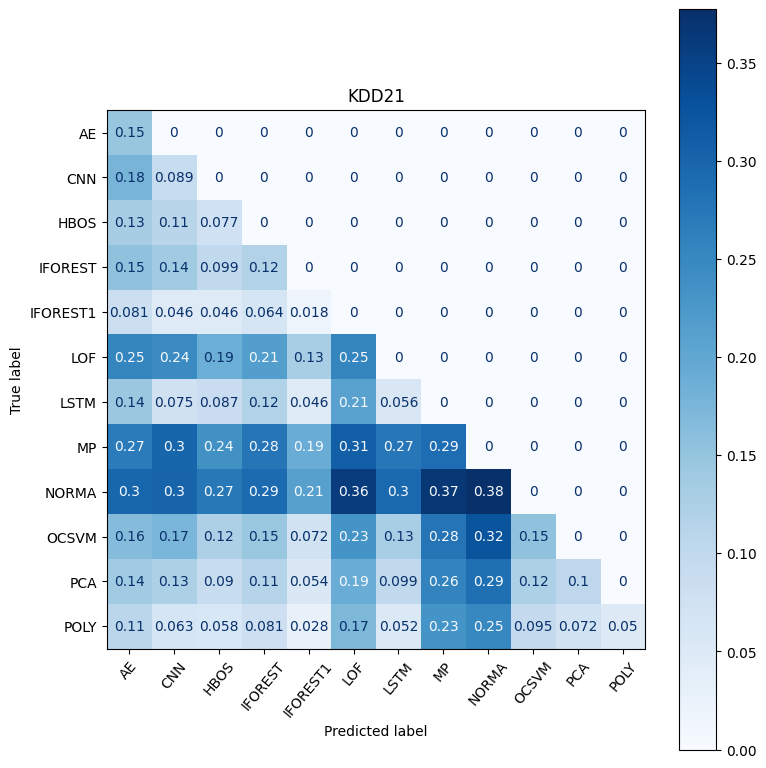

In [10]:
avg_matrices = []
for matrix, dataset in zip(matrices, datasets[:8]):
    avg_matrices.append(np.average(matrix, axis=0)) 

    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(avg_matrices[-1], display_labels=detectors)
    disp.plot(xticks_rotation=50, ax=ax, cmap="Blues")# "rocket_r"
    plt.tight_layout()
    plt.title(dataset)
    # plt.savefig(os.path.join(results_dir, f"avg_matrix_{dataset}"))
    plt.show()

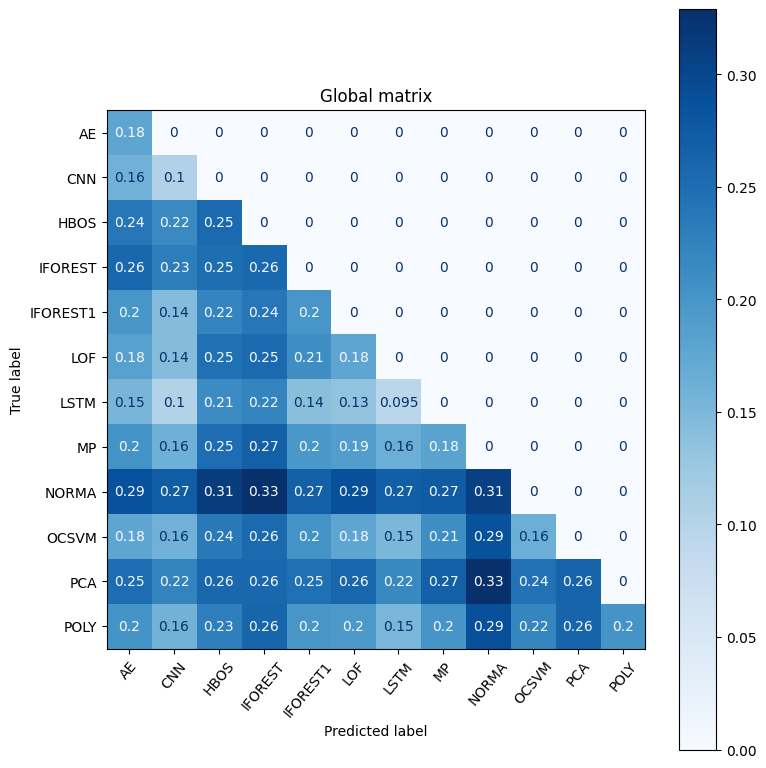

In [12]:
global_avg_matrix = np.average(np.stack(avg_matrices), axis=0)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(global_avg_matrix, display_labels=detectors)
disp.plot(xticks_rotation=50, ax=ax, cmap="Blues")# "rocket_r"
plt.tight_layout()
plt.title("Global matrix")
# plt.savefig(os.path.join(results_dir, f"avg_matrix_{dataset}"))
plt.show()

### Am I better with friends experiment

In [101]:
for i, dataset in enumerate(datasets):
    print(i, dataset)

0 SVDB
1 Genesis
2 GHL
3 SensorScope
4 ECG
5 OPPORTUNITY
6 SMD
7 KDD21
8 Daphnet
9 NAB
10 YAHOO
11 Dodgers
12 MITDB
13 IOPS
14 Occupancy
15 MGAB


In [106]:
detectors_combo_scores = {}
for i in detectors:
    detectors_combo_scores.update({i: {}})
    for k in detectors:
        detectors_combo_scores[i].update({k: []})
        
dataset_index = 3
# for curr_matrix in matrices[dataset_index:dataset_index + 1]:
for curr_matrix in matrices:
    for matrix in curr_matrix:
        for i in range(len(detectors)):
            for k in range(len(detectors)):
                if i > k:
                    detectors_combo_scores[detectors[i]][detectors[k]].append(matrix[i, k])
                else:
                    detectors_combo_scores[detectors[i]][detectors[k]].append(matrix[k, i])

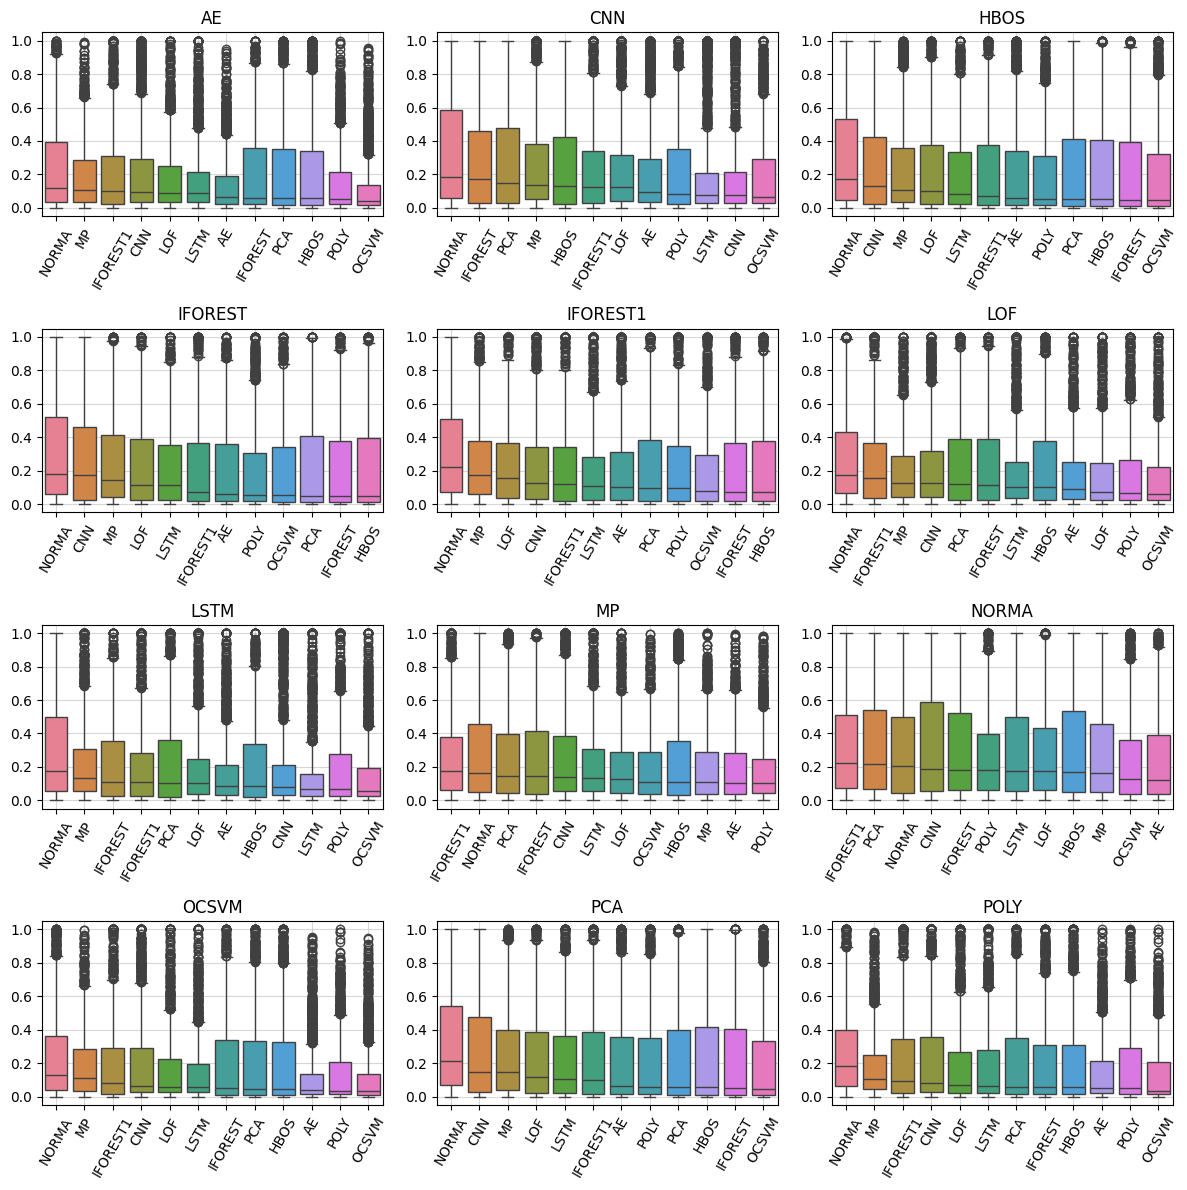

In [109]:
plt.figure(figsize=(12, 12))
# print(datasets[dataset_index])

for i, detector in enumerate(detectors):
    plt.subplot(4, 3, i + 1)
    
    tmp_df = pd.DataFrame(detectors_combo_scores[detector])
    # print(tmp_df.shape)
    meds = tmp_df.median()
    meds.sort_values(ascending=False, inplace=True)
    tmp_df = tmp_df[meds.index]
    
    sns.boxplot(tmp_df)
    plt.xticks(rotation=60)
    plt.title(detector)
    plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()